<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import Dense, ReLU, Input, Lambda, LSTM, Activation, MaxPool1D, Conv1D, Add, BatchNormalization, GlobalAveragePooling1D

from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras as keras
from tensorflow.keras.losses import Huber
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from google.colab import drive
import time

In [2]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_train = '/content/drive/My Drive/' + nov_dir + 'sp500_train.csv'
nov_test = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'

df_train = pd.read_csv(nov_train)
df_train['Date'] = pd.to_datetime(df_train['Date'], format = '%Y-%m-%d')
df_train['SP500'] = preprocessing.scale(df_train['SP500'])

print(df_train.shape)

look_back = 10
n_sample = len(df_train) - look_back
X, Y, A = [], [], []
for i in range(len(df_train) - look_back):
    X.append(df_train[['SP500']].iloc[i:(i+look_back)].values) # 観測データ
    Y.append(df_train[['SP500']].iloc[i+1:(i+look_back+1)].values) # 教師データ
    A.append(df_train[['SP500']].iloc[i+look_back].values) 
X_train = np.array(X)
y_train = np.array(Y)
A_train = np.array(A)

print(X_train.shape)
print(y_train.shape)


df_test = pd.read_csv(nov_test)
df_test['Date'] = pd.to_datetime(df_test['Date'], format = '%Y-%m-%d')
df_test['SP500'] = preprocessing.scale(df_test['SP500'])

print(df_test.shape)

look_back = 10
n_sample = len(df_test) - look_back
X, Y, A = [], [], []
for i in range(len(df_test) - look_back):
    X.append(df_test[['SP500']].iloc[i:(i+look_back)].values)
    Y.append(df_test[['SP500']].iloc[i+1:(i+look_back+1)].values)
    A.append(df_test[['SP500']].iloc[i+look_back].values)
X_test = np.array(X)
y_test = np.array(Y)
A_test = np.array(A)

print(X_test.shape)
print(y_test.shape)

Mounted at /content/drive/
(628, 2)
(618, 10, 1)
(618, 10, 1)
(882, 2)
(872, 10, 1)
(872, 10, 1)


# ストップウォッチ関数

In [3]:
def stopwatch(end_time,start_time):
  elapsed_time = int(end_time - start_time)

  elapsed_hour = elapsed_time // 3600
  elapsed_minute = (elapsed_time % 3600) // 60
  elapsed_second = (elapsed_time % 3600 % 60)

  mozi = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)
  return mozi

# モデル構築

In [4]:
class Brain:
    def __init__(self, loadmodel = False):
        self.filters = 64
        self.hidden_layers = 16
        self.obs_shape = (look_back, 1) # look_back=10
        self.nn_actions = 9
        self.kr = l2(0.0005)
        self.opt = Adam(learning_rate=0.0001, epsilon=0.001)
        self.units = 64

        if not loadmodel:
            self._main_network_layer()
        else:
            self._load()

    def _main_network_layer(self):
        x = input = Input(shape = self.obs_shape)
        arr = [[8, 5, 3, 1],[8, 5, 3, 1],[8, 5, 3]]
        filter = [self.filters, self.filters * 2, self.filters * 2]
        for a, f in zip(arr, filter):
            x = self._residual_layer(a, f)(x)

        print(x.shape) # (None, 10, 128)
        x = GlobalAveragePooling1D()(x) # (None, 128)
        x = Dense(1)(x) # (None, 1)

        model = Model(inputs = input, outputs= x)
        model.compile(loss = 'categorical_crossentropy', optimizer = self.opt, metrics=['accuracy'])
        self.model = model
        model.summary()

        dot_img_file = './resnet_model.png'
        tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


    def _residual_layer(self, arr, filter):
        def f(input_block):
            x = input_block
            for a in arr:
                if a >=  5:
                    x = self._conv_layer(filter, a, True)(x)
                elif a == 3:
                    x = self._conv_layer(filter, a, False)(x)
                else:
                    if len(arr) == 3:
                        input_block = BatchNormalization()(input_block)
                    else:
                        input_block = self._conv_layer(filter,
                                                       a, False)(input_block)

            x = Add()([x, input_block])
            x = Activation('relu')(x)
            return x
        return f

    def _conv_layer(self, filters, kernel_size  = 1, join_act = True):
        def f(input_block):
            x = Conv1D(filters=filters, kernel_size=kernel_size,
                       padding="same")(input_block)
            x = BatchNormalization()(x)
            if join_act:
                x = Activation('relu')(x)
            return x
        return f

In [5]:
brain = Brain()
model = brain.model

(None, 10, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 64)       576         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 10, 64)       0           ['batch_norma

# 学習

In [6]:
epochs = 100
batch_size = 8

start_time = time.time()
hist = model.fit(X_train, A_train, batch_size=batch_size, epochs=epochs, verbose=0) # X_train, y_train(618, 10, 1), (618, 10, 1)
print("学習時間 LSTM : ", stopwatch(time.time(),start_time))

学習時間 LSTM :  00:01:32


# 損失関数

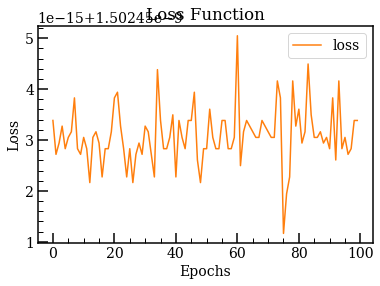

In [7]:
nov_dir2 = 'Colab Notebooks/workspace/export/'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["xtick.minor.width"] = 1.0
plt.rcParams["ytick.minor.width"] = 1.0
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.rcParams["font.size"] = 14
plt.rcParams["axes.linewidth"] = 1.5

loss = hist.history['loss']
epochs = len(loss)

plt.plot(range(epochs), loss, label="loss", color='tab:orange')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
nov_path2 = '/content/drive/My Drive/' + nov_dir2 + 'ResNet_lossfunc.png'

plt.savefig(nov_path2)
plt.show()
plt.close('all')

# 訓練結果

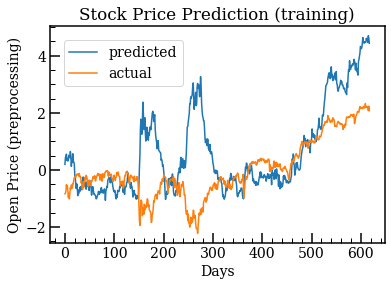

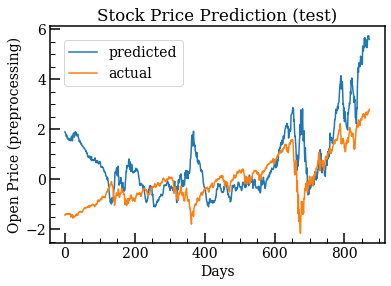

In [8]:
y1 = model.predict(X_train)

x1 = [ i for i in range(len(y1))]

y2 = A_train
x2 = [ i for i in range(len(y2))]

plt.figure()
plt.plot(x1, y1, label="predicted")
plt.plot(x2, y2, label="actual")
plt.legend(borderaxespad=1)
plt.title('Stock Price Prediction (training)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')

nov_path3 = '/content/drive/My Drive/' + nov_dir2 + 'ResNet_training.png'
plt.savefig(nov_path3)
plt.show()
plt.close('all')



y1 = model.predict(X_test)

x1 = [ i for i in range(len(y1))]

y2 = A_test
x2 = [ i for i in range(len(y2))]

plt.figure()
plt.plot(x1, y1, label="predicted")
plt.plot(x2, y2, label="actual")
plt.legend(borderaxespad=1)
plt.title('Stock Price Prediction (test)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')

nov_path4 = '/content/drive/My Drive/' + nov_dir2 + 'ResNet_test.png'
plt.savefig(nov_path4)
plt.show()
plt.close('all')